In [1]:
import bpy
blend_file_path = "networkx.blend"
bpy.ops.wm.open_mainfile(filepath=blend_file_path)

def draw_network(node_positions, edges, sphere_radius = 0.1):

    # Function to delete all objects in a collection
    def clear_collection(collection):
        for obj in collection.objects:
            bpy.data.objects.remove(obj, do_unlink=True)
    
    # Function to get or create a collection
    def get_or_create_collection(name, parent=None):
        collection = bpy.data.collections.get(name)
        if not collection:
            collection = bpy.data.collections.new(name)
            if parent:
                parent.children.link(collection)
        else:
            clear_collection(collection)
        return collection
    
    # Get or create the "Graph" collection and its children "Nodes" and "Edges"
    graph_collection = get_or_create_collection("Graph", bpy.context.scene.collection)
    edges_collection = get_or_create_collection("Edges", graph_collection)
    nodes_collection = get_or_create_collection("Nodes", graph_collection)
    
    # Clear the Nodes collection
    clear_collection(nodes_collection)
    
    # Create spheres at the points and add them to the Nodes collection
    spheres = {}
    material = bpy.data.materials.get("Material1")
    
    for key, coords in node_positions.items():
        bpy.ops.mesh.primitive_uv_sphere_add(location=coords, radius=sphere_radius)
        sphere = bpy.context.object
        sphere.name = f"my_point{key}"
        sphere.data.materials.append(material)
        nodes_collection.objects.link(sphere)
        bpy.context.collection.objects.unlink(sphere)
        spheres[key] = sphere
    
    # Create plane objects at the center of each edge and add geometry nodes modifier
    for i, (edge1, edge2) in enumerate(edges):
        bpy.ops.mesh.primitive_plane_add(size=0.2)  
        plane = bpy.context.object
        plane.name = f"edge{i+1}"
        edges_collection.objects.link(plane)
        bpy.context.collection.objects.unlink(plane)
        
        node_group = bpy.data.node_groups.get("connector_goenode")
        modifier = plane.modifiers.new(name="Connect", type='NODES')
        modifier.node_group = node_group 
        
        # Set the Group input node to point to the corresponding spheres
        sphere1 = bpy.data.objects.get(f"my_point{edge1}")
        sphere2 = bpy.data.objects.get(f"my_point{edge2}")
        
        modifier["Socket_2"] = sphere1
        modifier["Socket_3"] = sphere2
        modifier["Socket_4"] = material

Read blend: "/Users/jan-hendrik/projects/ipyblender-gui/group_network.blend"


In [2]:
import networkx as nx
import bpy

G = nx.balanced_tree(4, 4)
node_positions = nx.spring_layout(G, dim=3, scale=1.9)
edges = list(G.edges)
draw_network(node_positions, edges, sphere_radius = 0.05)

In [3]:
G = nx.balanced_tree(6, 2)
node_positions = nx.spring_layout(G, dim=3, scale=1.9)
edges = list(G.edges)
draw_network(node_positions, edges, sphere_radius = 0.1)

Saved: '/tmp/test.png'
Time: 00:00.20 (Saving: 00:00.01)



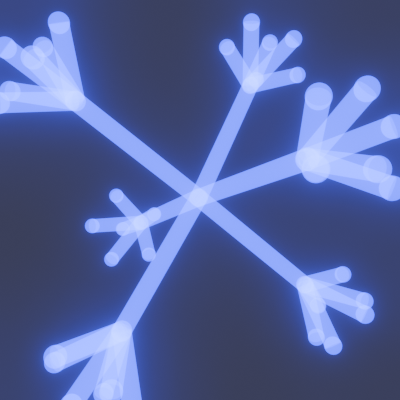

In [5]:
from IPython.display import display, Image

bpy.context.scene.render.resolution_x = 400
bpy.context.scene.render.resolution_y = 400

path = "/tmp/test.png"
bpy.context.scene.render.filepath = path
bpy.ops.render.render(write_still=True)

display(Image(filename=path , width=400))